# Importing the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
print(tf.config.list_physical_devices())
print(tf.__version__)
print(tf.keras.__version__)

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
2.6.0
The scikit-learn version is 1.0.
Python version
3.8.11 (default, Aug  3 2021, 15:09:35) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=8, micro=11, releaselevel='final', serial=0)


2021-09-25 14:28:03.135044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 14:28:03.139861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 14:28:03.140241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for dataset in ['train', 'test', 'val']:
        dataset_dir = os.path.join(data_dir, dataset)
        for label in labels: 
            path = os.path.join(dataset_dir, label)
            class_num = labels.index(label)
            print(f'Currently reading: {path}')
            for img in os.listdir(path):
                if (img == '.DS_Store'):
                    continue
                try:
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(f'Error with {img}: {e}')
    return np.array(data, dtype=object)

# Loading the Dataset

In [4]:
data = np.load('data.npy', allow_pickle=True)

In [5]:
# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

In [6]:
train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])
train.shape, val.shape, test.shape

((4392, 2), (292, 2), (1172, 2))

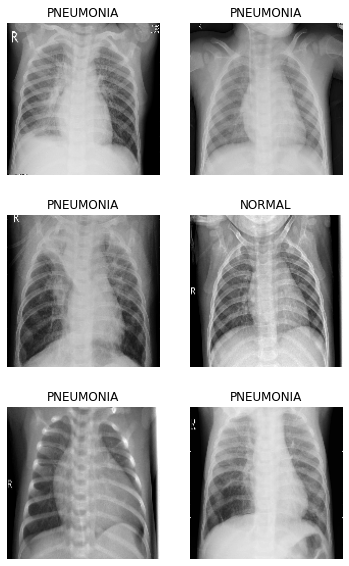

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(6,10), facecolor='white')
for idx, item in enumerate(np.random.randint(0, train.shape[0], 6)):
    ax[int(idx/2)][idx%2].imshow(train[item][0], cmap='gray')
    ax[int(idx/2)][idx%2].set_title(labels[train[item][1]])
    ax[int(idx/2)][idx%2].axis('off')

plt.savefig('data_pics.png')

Text(0.5, 1.0, 'PNEUMONIA')

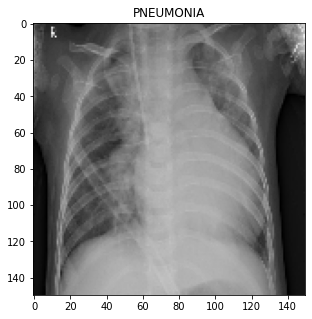

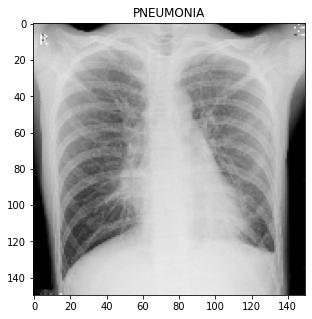

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [9]:
tr0 = np.count_nonzero(train[:, 1] == 0)
tr1 = np.count_nonzero(train[:, 1] == 1)
te0 = np.count_nonzero(test[:, 1] == 0)
te1 = np.count_nonzero(test[:, 1] == 1)
va0 = np.count_nonzero(val[:, 1] == 0)
va1 = np.count_nonzero(val[:, 1] == 1)
print(tr0, tr1)
print(te0, te1)
print(va0, va1)

3191 1201
856 316
226 66


In [10]:
print(tr0 + te0 + va0)
print(tr1 + te1 + va1)
print(tr0 + te0 + va0 + tr1 + te1 + va1)

4273
1583
5856


In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [14]:
print(x_train[0].shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(150, 150, 1) (4392, 150, 150, 1) (4392,) (292, 150, 150, 1) (292,) (1172, 150, 150, 1) (1172,)


# Data Augmentation

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

In [16]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [17]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [18]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
    model.add(BatchNormalization())
    model.add(ChannelAttention(32, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(ChannelAttention(64, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(ChannelAttention(64, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(ChannelAttention(128, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(ChannelAttention(256, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    
    return model

In [19]:
n_epoch = 50

In [21]:
lrs = ['0.01', '0.001', '0.0001']
for slr in lrs:
    lr = float(slr)
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    model = create_model()
    model.compile(optimizer = optim, loss = 'binary_crossentropy' , metrics = ['accuracy'])
    
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', patience=2, verbose=1, factor=0.8
    )
    
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 16), epochs=n_epoch , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
    
    print("-"*100)
    print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
    print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
    print("-"*100)
    print("\n"*5)
    
    np.save(f'lrs_{slr}.npy',history.history)

2021-09-22 23:02:13.493651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 23:02:13.494173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 23:02:13.494558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 23:02:13.495017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/50


2021-09-22 23:02:14.858612: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


275/275 [==============================] - 7s 19ms/step - loss: 0.3698 - accuracy: 0.8422 - val_loss: 1.0915 - val_accuracy: 0.5068
Epoch 2/50
275/275 [==============================] - 6s 21ms/step - loss: 0.2799 - accuracy: 0.8921 - val_loss: 3.9635 - val_accuracy: 0.7740
Epoch 3/50
275/275 [==============================] - 5s 17ms/step - loss: 0.2786 - accuracy: 0.8864 - val_loss: 0.2437 - val_accuracy: 0.8870
Epoch 4/50
275/275 [==============================] - 5s 19ms/step - loss: 0.2651 - accuracy: 0.8994 - val_loss: 0.4155 - val_accuracy: 0.7808
Epoch 5/50
275/275 [==============================] - 5s 18ms/step - loss: 0.2380 - accuracy: 0.9107 - val_loss: 6.3893 - val_accuracy: 0.2637

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
Epoch 6/50
275/275 [==============================] - 5s 19ms/step - loss: 0.2105 - accuracy: 0.9246 - val_loss: 0.1435 - val_accuracy: 0.9589
Epoch 7/50
275/275 [==============================] - 5s 17ms/step - loss

# Analysis after Model Training

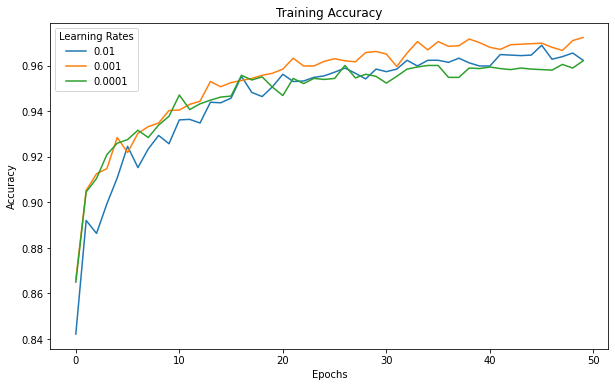

In [27]:
lrs = ['0.01', '0.001', '0.0001']
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(facecolor='white')
fig.set_size_inches(10, 6)

ax.set_title('Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

colors = ['C0', 'C1', 'C2']

for idx, lr in enumerate(lrs):
    hist = np.load(f'lrs_{lr}.npy', allow_pickle='true').item()
    ax.plot(epochs, hist['accuracy'], color=colors[idx], label = lr)

ax.legend(title="Learning Rates")

plt.savefig('lracc', bbox_inches='tight')

plt.show()

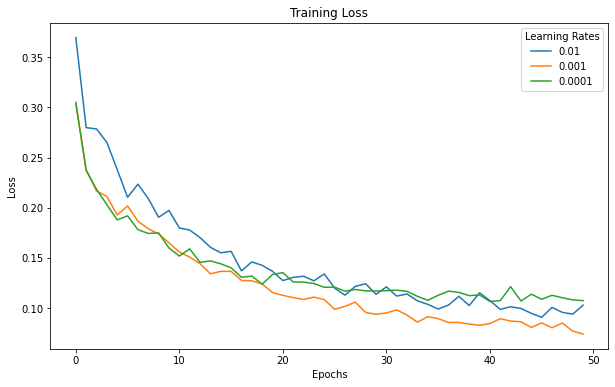

In [28]:
lrs = ['0.01', '0.001', '0.0001']
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(facecolor='white')
fig.set_size_inches(10, 6)

ax.set_title('Training Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

colors = ['C0', 'C1', 'C2']

for idx, lr in enumerate(lrs):
    hist = np.load(f'lrs_{lr}.npy', allow_pickle='true').item()
    ax.plot(epochs, hist['loss'], color=colors[idx], label = lr)

ax.legend(title="Learning Rates")

plt.savefig('lrloss', bbox_inches='tight')

plt.show()

In [ ]:
lrs = ['0.01', '0.001', '0.0001']
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(1,2, facecolor='white')
fig.set_size_inches(20,5)

ax[0].set_title('Training Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].set_title('Training Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

max_acc = -1
best_lr = -1

for idx, lr in enumerate(lrs):
    hist = np.load(f'lrs_{lr}.npy', allow_pickle='true').item()
    ax[0].plot(epochs , hist['accuracy'] , label = lr)
    ax[1].plot(epochs , hist['loss'] , label = lr)
    
    last_val = hist['accuracy'][-1]
    print(f'{lr}: {last_val}')
    if last_val > max_acc:
        max_acc = last_val
        best_lr = lr

ax[0].legend(title="Learning Rates")
ax[1].legend(title="Learning Rates")

# plt.savefig('learning rates')

plt.show()

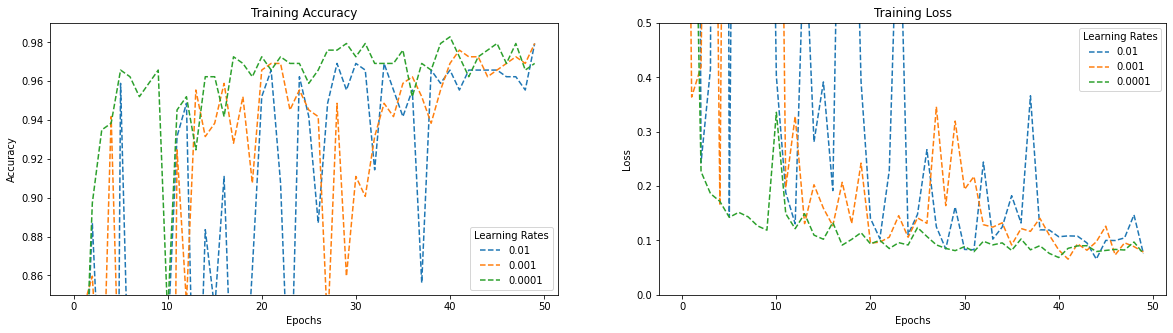

In [43]:
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(1,2, facecolor='white')
fig.set_size_inches(20,5)

ax[0].set_title('Training Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].set_title('Training Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

for idx, lr in enumerate(lrs):
    hist = np.load(f'lrs_{lr}.npy', allow_pickle='true').item()
    ax[0].plot(epochs , hist['val_accuracy'] , f'C{idx}--', label = lr)
    ax[1].plot(epochs , hist['val_loss'] , f'C{idx}--', label = lr)

ax[0].legend(title="Learning Rates")
ax[1].legend(title="Learning Rates")

ax[0].set_ylim(0.85, 0.99)
ax[1].set_ylim(0, 0.5)

plt.show()

In [24]:
print(f'The learning rate with the highest final accuracy is {best_lr}.')

The learning rate with the highest final accuracy is 0.001.


# Batch Size

In [16]:
best_lr = 0.001

In [ ]:
batch_sizes = [8, 16, 32, 64]
for batch_size in batch_sizes:
    optim = tf.keras.optimizers.Adam(learning_rate=float(best_lr))
    print(f'Using lr of {best_lr}, batch size of {batch_size}')
    model = create_model()
    model.compile(optimizer = optim, loss = 'binary_crossentropy' , metrics = ['accuracy'])
    
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', patience=2, verbose=1, factor=0.8
    )
    
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=n_epoch , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
    
    print("-"*100)
    print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
    print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
    print("-"*100)
    print("\n"*5)
    
    np.save(f'batchsz_{batch_size}.npy',history.history)

## Analysis after model training

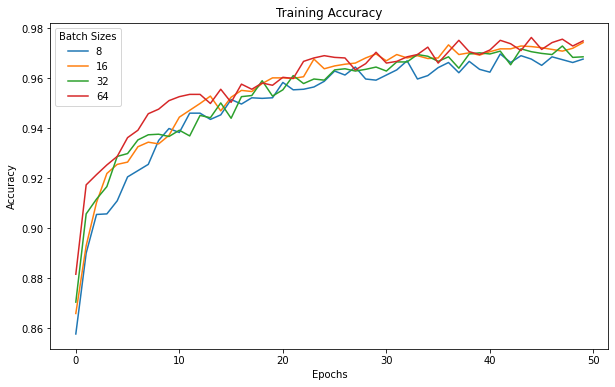

In [23]:
batch_sizes = [8, 16, 32, 64]
n_epoch=50
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(facecolor='white')
fig.set_size_inches(10, 6)

ax.set_title('Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

for idx, batch_size in enumerate(batch_sizes):
    hist = np.load(f'batchsz_{batch_size}.npy', allow_pickle='true').item()
    ax.plot(epochs, hist['accuracy'], label = batch_size)

ax.legend(title="Batch Sizes")

plt.savefig('bsacc', bbox_inches='tight')

plt.show()

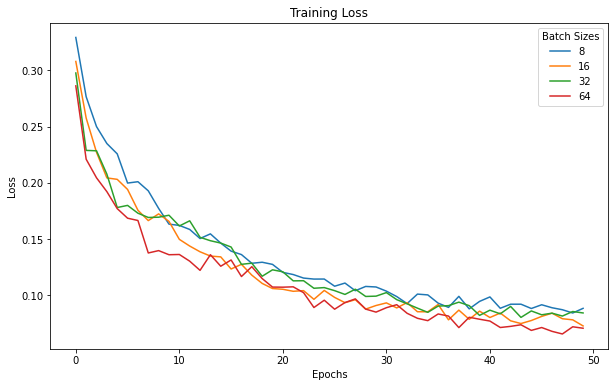

In [22]:
batch_sizes = [8, 16, 32, 64]
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(facecolor='white')
fig.set_size_inches(10, 6)

ax.set_title('Training Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

for idx, batch_size in enumerate(batch_sizes):
    hist = np.load(f'batchsz_{batch_size}.npy', allow_pickle='true').item()
    ax.plot(epochs, hist['loss'], label = batch_size)

ax.legend(title="Batch Sizes")

plt.savefig('bsloss', bbox_inches='tight')

plt.show()

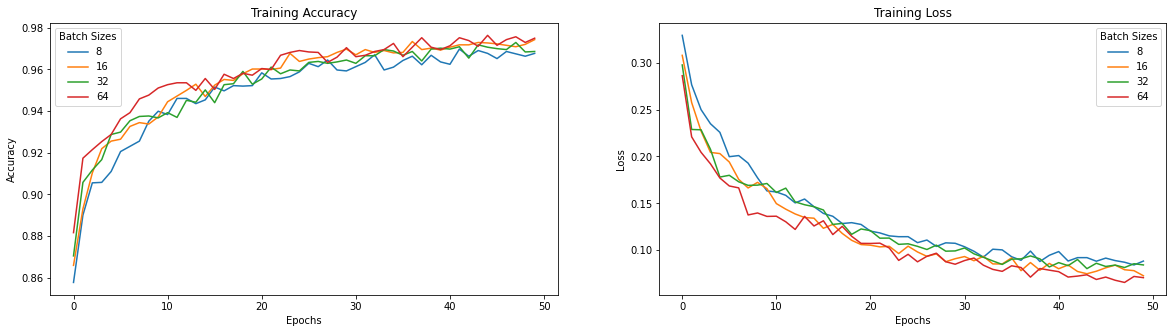

In [22]:
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(1,2, facecolor='white')
fig.set_size_inches(20,5)

ax[0].set_title('Training Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].set_title('Training Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

for idx, batch_size in enumerate(batch_sizes):
    hist = np.load(f'batchsz_{batch_size}.npy', allow_pickle='true').item()
    ax[0].plot(epochs , hist['accuracy'] , f'C{idx}', label = batch_size)
    ax[1].plot(epochs , hist['loss'] , f'C{idx}', label = batch_size)

ax[0].legend(title="Batch Sizes")
ax[1].legend(title="Batch Sizes")

plt.savefig('batch sizes')

plt.show()

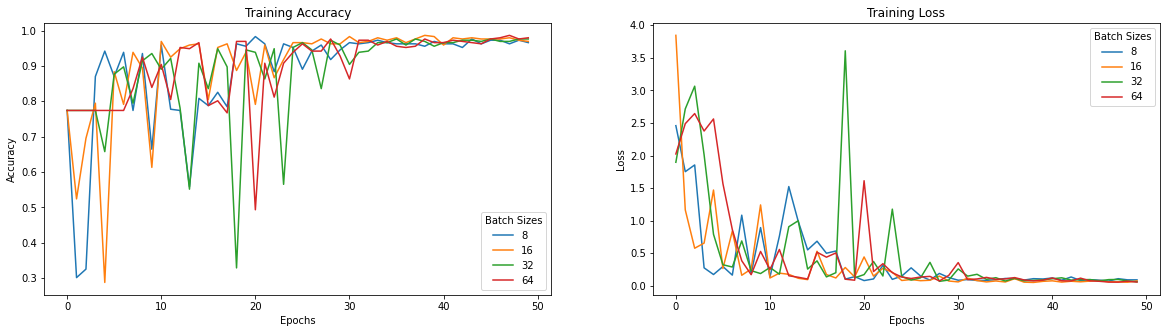

In [23]:
epochs = [i for i in range(n_epoch)]
fig , ax = plt.subplots(1,2, facecolor='white')
fig.set_size_inches(20,5)

ax[0].set_title('Training Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].set_title('Training Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

for idx, batch_size in enumerate(batch_sizes):
    hist = np.load(f'batchsz_{batch_size}.npy', allow_pickle='true').item()
    ax[0].plot(epochs , hist['val_accuracy'] , f'C{idx}', label = batch_size)
    ax[1].plot(epochs , hist['val_loss'] , f'C{idx}', label = batch_size)

ax[0].legend(title="Batch Sizes")
ax[1].legend(title="Batch Sizes")

plt.savefig('batch sizes')

plt.show()